### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [3]:
#%load_ext nb_black

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a> 

In [4]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [5]:
dataset = datasets.ImageFolder("Dataset/aug", transform=transform)

In [6]:
dataset

Dataset ImageFolder
    Number of datapoints: 4280
    Root location: Dataset/aug
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [7]:
indices = list(range(len(dataset)))

In [8]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [9]:
validation = int(np.floor(0.70 * split))  # validation

In [10]:
print(0, validation, split, len(dataset))

0 2546 3638 4280


In [11]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :2546
length of validation size :1092
length of test size :1734


In [12]:
np.random.shuffle(indices)

### Split into Train and Test

In [13]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [14]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [15]:
targets_size = len(dataset.class_to_idx)

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [16]:
model = models.vgg16(pretrained=True)

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for params in model.parameters():
     params.requires_grad = False

In [18]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
n_features = model.classifier[0].in_features
n_features

25088

In [20]:
model.classifier = nn.Sequential(
    nn.Linear(n_features, 1024),
     nn.ReLU(),
    nn.Dropout(0.4),
     nn.Linear(1024, targets_size),
)

In [21]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Original Modeling

In [22]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
device = "cpu"

In [25]:
model = CNN(targets_size)

In [26]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [27]:
from torchsummary import summary

summary(model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─BatchNorm2d: 2-3                  [-1, 32, 224, 224]        64
|    └─Conv2d: 2-4                       [-1, 32, 224, 224]        9,248
|    └─ReLU: 2-5                         [-1, 32, 224, 224]        --
|    └─BatchNorm2d: 2-6                  [-1, 32, 224, 224]        64
|    └─MaxPool2d: 2-7                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-9                         [-1, 64, 112, 112]        --
|    └─BatchNorm2d: 2-10                 [-1, 64, 112, 112]        128
|    └─Conv2d: 2-11                      [-1, 64, 112, 112]        36,928
|    └─ReLU: 2-12                        [-1, 64, 112, 112]        --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─ReLU: 2-2                         [-1, 32, 224, 224]        --
|    └─BatchNorm2d: 2-3                  [-1, 32, 224, 224]        64
|    └─Conv2d: 2-4                       [-1, 32, 224, 224]        9,248
|    └─ReLU: 2-5                         [-1, 32, 224, 224]        --
|    └─BatchNorm2d: 2-6                  [-1, 32, 224, 224]        64
|    └─MaxPool2d: 2-7                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 64, 112, 112]        18,496
|    └─ReLU: 2-9                         [-1, 64, 112, 112]        --
|    └─BatchNorm2d: 2-10                 [-1, 64, 112, 112]        128
|    └─Conv2d: 2-11                      [-1, 64, 112, 112]        36,928
|    └─ReLU: 2-12                        [-1, 64, 112, 112]        --
| 

In [28]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [29]:
def batch_gd(model, criterion, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss= []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)
        
        validation_losses[e] = validation_loss
        train_losses[e] = train_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [30]:
device = "cpu"

In [31]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [32]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Epoch : 1/5 Train_loss:6.583 Test_loss:3.828 Duration:0:04:54.102339
Epoch : 2/5 Train_loss:3.088 Test_loss:3.332 Duration:0:04:51.863239
Epoch : 3/5 Train_loss:2.457 Test_loss:2.782 Duration:0:04:43.041828
Epoch : 4/5 Train_loss:2.067 Test_loss:2.750 Duration:0:04:39.004345
Epoch : 5/5 Train_loss:1.855 Test_loss:2.482 Duration:0:04:37.314726


### Save the Model

In [33]:
torch.save(model.state_dict() , 'plant_disease_model.pt')

### Load Model

In [34]:
targets_size=39
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [35]:
# %matplotlib notebook

### Plot the loss

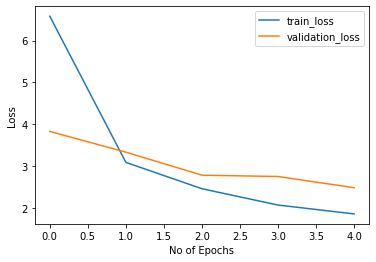

In [36]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [37]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [38]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [39]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.746268656716418
Test Accuracy : 0.5654205607476636
Validation Accuracy : 0.5769230769230769


### Single Image Prediction

In [45]:
transform_index_to_disease = dataset.class_to_idx

In [46]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [47]:
data = pd.read_csv("disease_info.csv", encoding="cp1252")

In [48]:
from PIL import Image
import torchvision.transforms.functional as TF

In [49]:
def single_prediction(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

In [50]:
single_prediction("test_images/Apple_ceder_apple_rust.JPG")

Original :  Apple_ceder_apple_rust
Apple : Cedar rust


### Wrong Prediction

In [51]:
single_prediction("test_images/Apple_scab.JPG")

Original :  Apple_scab
Apple : Scab


In [52]:
single_prediction("test_images/Grape_esca.JPG")

Original :  Grape_esca
Grape : Esca | Black Measles


In [53]:
single_prediction("test_images/apple_black_rot.JPG")

Original :  apple_black_rot
Raspberry : Healthy


In [54]:
single_prediction("test_images/apple_healthy.JPG")

Original :  apple_healthy
Apple : Healthy


In [55]:
single_prediction("test_images/background_without_leaves.jpg")

Original :  background_without_leaves
Background Without Leaves


In [56]:
single_prediction("test_images/blueberry_healthy.JPG")

Original :  blueberry_healthy
Blueberry : Healthy


In [57]:
single_prediction("test_images/cherry_healthy.JPG")

Original :  cherry_healthy
Pepper bell : Healthy


In [58]:
single_prediction("test_images/cherry_powdery_mildew.JPG")

Original :  cherry_powdery_mildew
Apple : Cedar rust


In [59]:
single_prediction("test_images/corn_cercospora_leaf.JPG")

Original :  corn_cercospora_leaf
Corn : Northern Leaf Blight


In [60]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [61]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [62]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Squash : Powdery Mildew


In [63]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Grape : Esca | Black Measles


In [64]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Raspberry : Healthy


In [65]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Black Rot


In [66]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Tomato : Yellow Leaf Curl Virus


In [67]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [68]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [69]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Raspberry : Healthy


In [70]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [71]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Tomato : Septoria Leaf Spot


In [72]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Raspberry : Healthy


In [73]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Tomato : Late Blight


In [74]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [75]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Pepper bell : Healthy


In [76]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Tomato : Late Blight


In [77]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Tomato : Healthy


In [78]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [79]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [80]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Bacterial Spot


In [81]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Peach : Healthy


In [82]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [83]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Spider Mites | Two-Spotted Spider Mite


In [84]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [85]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [86]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [87]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [88]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [89]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus
